# 주식 예측 프로젝트

# - 목차
1. 시계열 데이터 준비
2. 데이터 전처리
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측하기   
 7.1 TSAL   
 7.2 APPLE   
 7.3 NVIDA   

- 프로젝트 정리

## 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume   
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인.   
- 하루의 장이 마감하였을 때의 가격인 종가(Close)만 사용.

## 2. 데이터 전처리

In [2]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

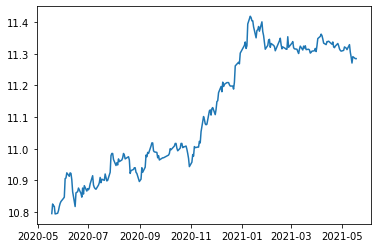

In [3]:
#로그변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 3. 시계열 안정성 분석

In [4]:
#일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

- 이 데이터셋은 월 단위로 발생하는 시계열이기 때문에 12개월 단위로 주기성이 있어 window를 12로 두었다.

In [5]:
#statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

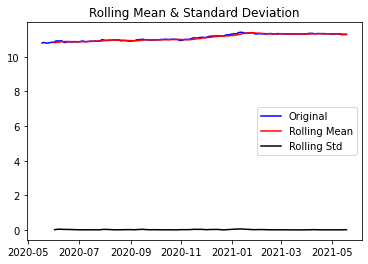

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


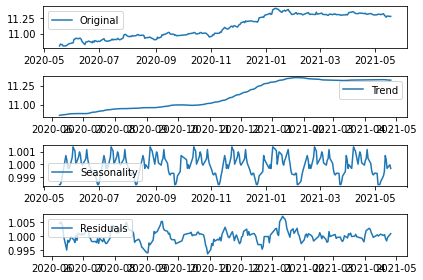

In [6]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- residual의 p-value는 6.234854e-08로 아주 낮은 값을 보이기 대문에 예측 가능한 수준의 안정적인 시계열이라고 할 수 있다.

## 4. 학습, 테스트 데이터셋 생성
- 분리 비율은 학습:테스트 = 9:1
- 나중 데이터를 테스트용으로 사용하는 것이 타당함.

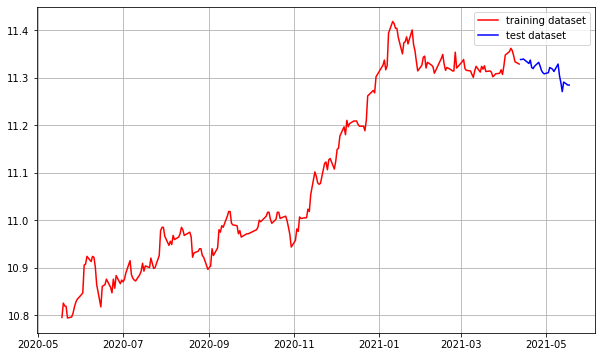

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

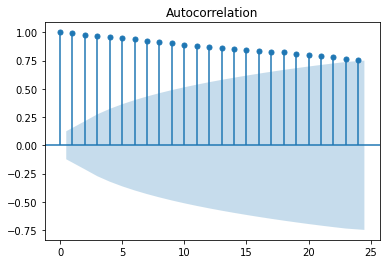

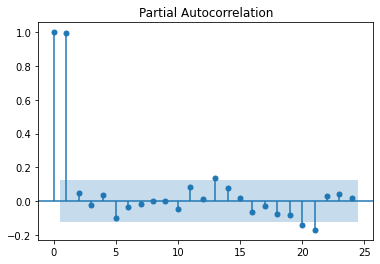

In [9]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 PACF 그래프를 볼 때 p 값은 1이 적합하다는 것을 알 수 있다. 
- ACF는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있으며 q에 대해서는 적합한 값이 없어 보인다.
- 따라서 MA를 고려할 필요가 없으므로 q 값은 0으로 두었다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


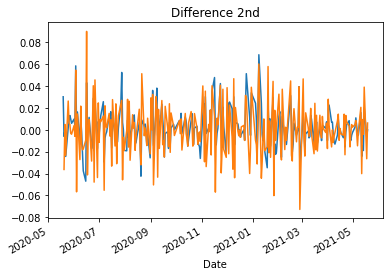

In [10]:
#차분 안정성 확인 -> d 구하기

#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분보다 1차 차분이 훨씬 더 안정화 된 상태였기 때문에 d 값은 1이 적합하다고 판단했다.

## 6. ARIMA 모델 훈련과 테스트

In [15]:
from statsmodels.tsa.arima_model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 1, 8))  

#fitting model
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 8)   Log Likelihood                 586.772
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 31 Aug 2021   AIC                          -1151.544
Time:                        10:41:33   BIC                          -1114.016
Sample:                             1   HQIC                         -1136.396
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      2.247      0.025       0.000       0.004
ar.L1.D.Close    -0.7031      0.267     -2.633      0.008      -1.226      -0.180
ma.L1.D.Close     0.7304      0.268     

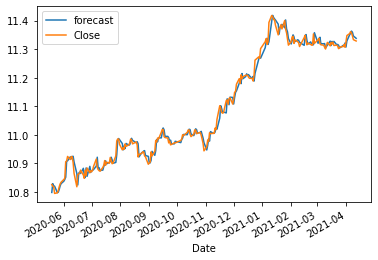

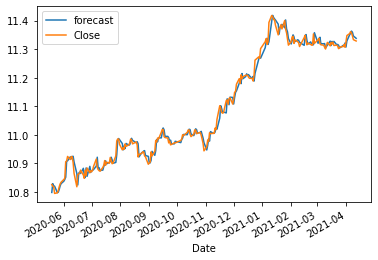

In [16]:
#훈련 결과 시각화
fitted_m.plot_predict()

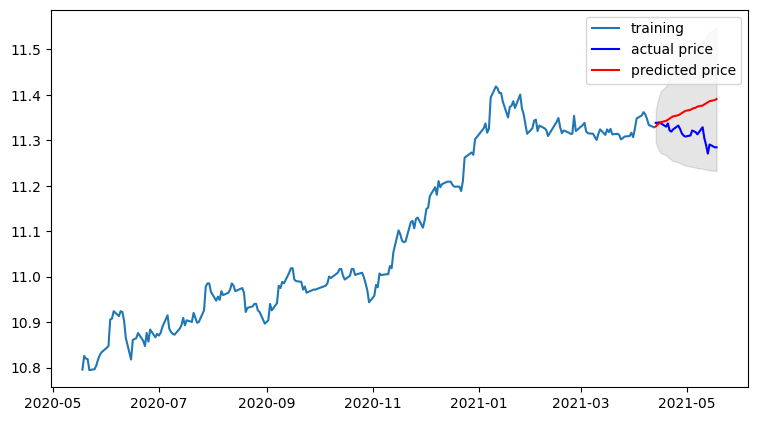

In [17]:
#테스트 데이터 구간의 데이터 예측

#Forecast : 결과가 fc에 담김.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  #예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  #예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 함.
#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산.

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23803929.40619436
MAE:  3975.940782494801
RMSE:  4878.92707531014
MAPE: 4.91%


- 최종적으로 예측 모델의 메트릭으로 활경하기에 적당한 MAPE 기준으로 4.91% 정도의 오차율을 보였다. 
- 전반적으로 상승하는 트렌트를 가진 데이터였으며 기간 또한 그리 길지 않은 데이터였기 때문에 MAPE가 좋게 나온 것 같았기에, 이후 다른 종목을 예측할 때는 기간을 늘려서 데이터를 다운받았다.

## 7. 다른 주식 종목 예측하기

## 7.1 TSLA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#데이터 로드
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data1/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-08-31    42.402000
2016-09-01    40.153999
2016-09-02    39.556000
2016-09-06    40.566002
2016-09-07    40.341999
Name: Close, dtype: float64

In [2]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

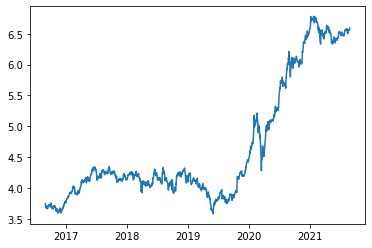

In [3]:
#로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

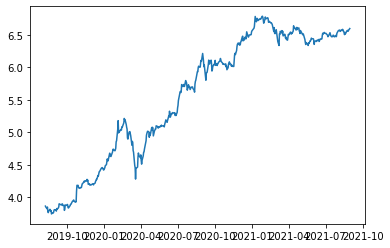

In [4]:
#데이터의 기간 조정하여 재 시도
ts_log = ts_log['2019-08-08' : ]
plt.plot(ts_log)

In [5]:
#일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


#statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

- 이 데이터셋은 월 단위로 발생하는 시게열이므로 12개월 단위로 주기성이 있기 때문애 window를 12로 두었다.

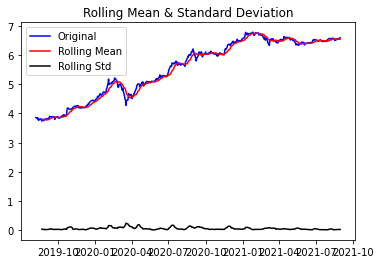

Results of Dickey-Fuller Test:
Test Statistic                  -1.382267
p-value                          0.590747
#Lags Used                       0.000000
Number of Observations Used    519.000000
Critical Value (1%)             -3.443013
Critical Value (5%)             -2.867125
Critical Value (10%)            -2.569745
dtype: float64


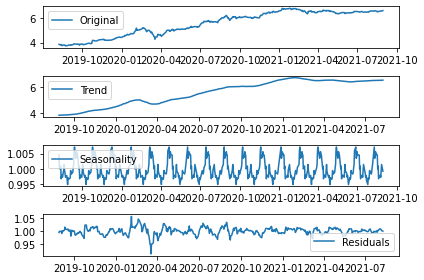

In [6]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.758101e+00
p-value                        9.616161e-12
#Lags Used                     3.000000e+00
Number of Observations Used    4.860000e+02
Critical Value (1%)           -3.443877e+00
Critical Value (5%)           -2.867505e+00
Critical Value (10%)          -2.569947e+00
dtype: float64


- residual의 p-value가 아주 낮은 값을 보여주는 것을 보아 예측 가능한 수준의 안정적인 시계열이라고 볼 수 있다.

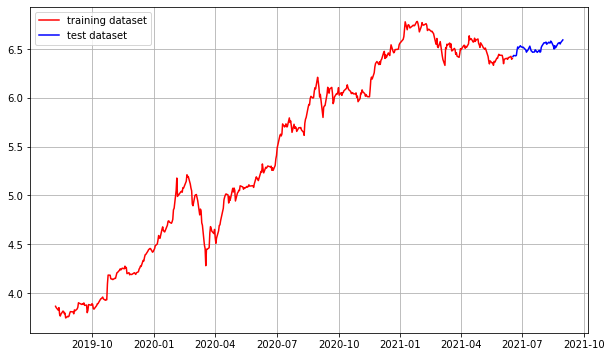

In [8]:
#데이터셋 분리 - 9:1로 분리함.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

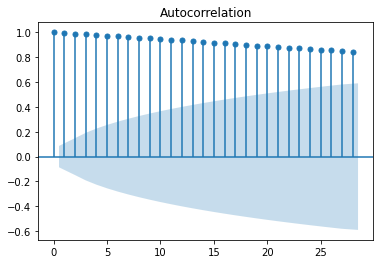

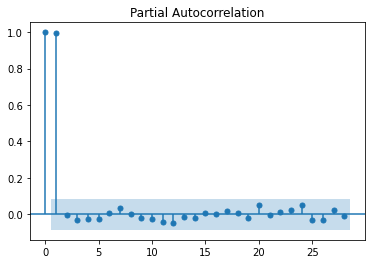

In [9]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p가 2 이상인 구간에서는 PACF는 거의 0에 가깝기 때문에 PACF 그래프를 근거로 p값이 1이 적합하다고 판단했다.
- ACF는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있다. 
- q에 대해서는 적합한 값이 없어 보이기 때문에 q 값은 0으로 두었다.

Results of Dickey-Fuller Test:
Test Statistic                 -22.805517
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    518.000000
Critical Value (1%)             -3.443037
Critical Value (5%)             -2.867136
Critical Value (10%)            -2.569750
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.222710e+01
p-value                        1.074291e-22
#Lags Used                     1.100000e+01
Number of Observations Used    5.060000e+02
Critical Value (1%)           -3.443340e+00
Critical Value (5%)           -2.867269e+00
Critical Value (10%)          -2.569821e+00
dtype: float64


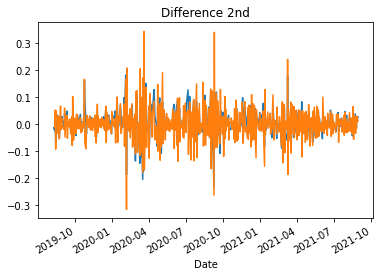

In [10]:
#차분 안정성 확인 -> d 구하기

#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분까지 구했을 때 2차 차분보다 1차 차분이 더 안정화 된 상태였기 때문에 d 값은 1로 두었다.

In [15]:
#모델 학습 

from statsmodels.tsa.arima_model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 1, 0))  

#fitting model
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  467
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 757.346
Method:                       css-mle   S.D. of innovations              0.048
Date:                Tue, 31 Aug 2021   AIC                          -1508.692
Time:                        11:32:15   BIC                          -1496.253
Sample:                             1   HQIC                         -1503.797
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0054      0.002      2.473      0.013       0.001       0.010
ar.L1.D.Close    -0.0052      0.046     -0.113      0.910      -0.096       0.085
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

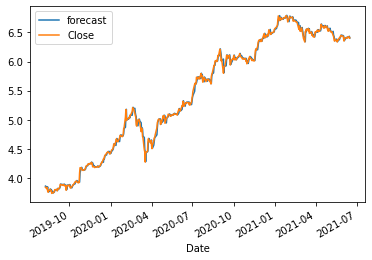

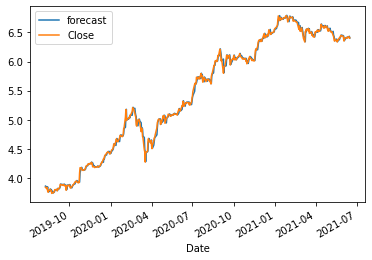

In [16]:
#훈련 결과 시각화
fitted_m.plot_predict()

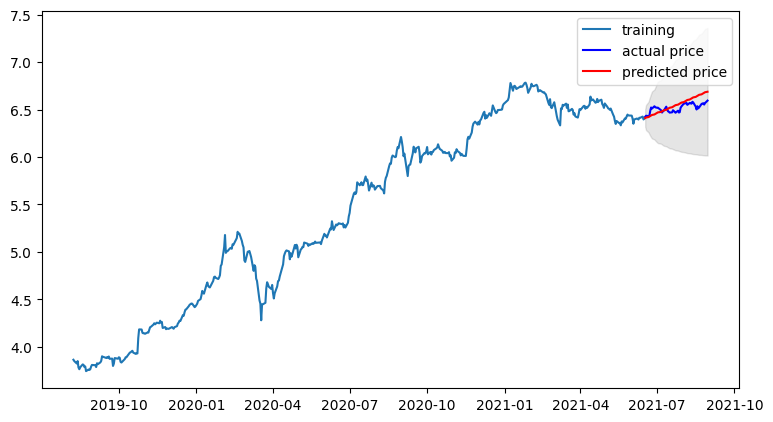

In [17]:
#테스트 데이터 구간의 데이터 예측

#Forecast : 결과가 fc에 담김.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  #예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  #예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 함.
#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산.

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2405.8676071975565
MAE:  40.62735656937439
RMSE:  49.0496443126508
MAPE: 5.96%


## 7.2 APPLE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#데이터 로드
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data1/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-08-31    26.525000
2016-09-01    26.682501
2016-09-02    26.932501
2016-09-06    26.924999
2016-09-07    27.090000
Name: Close, dtype: float64

In [3]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

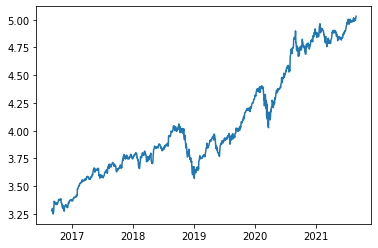

In [4]:
#로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

- 테슬라와는 달리 급등하는 구간이 없는 전반적으로 우상향인 경향을 보였기 때문에 따로 기간 조정을 해주지 않았다.

In [5]:
#일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
#마찬가지로 월 단위로 발생하는 시게열이므로 12개월 단위로 주기성이 있기 때문애 window를 12로 둠.
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


#statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

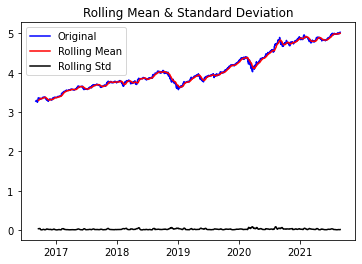

Results of Dickey-Fuller Test:
Test Statistic                   -0.069437
p-value                           0.952399
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


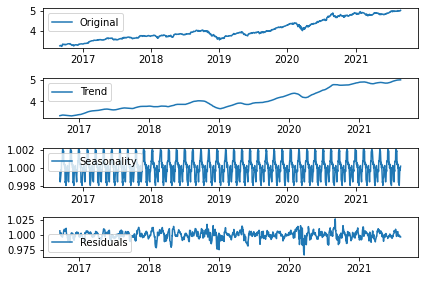

In [6]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.494528e+00
p-value                        3.578385e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64


- residual의 p-value가 아주 낮은 값을 보여주는 것을 보아 예측 가능한 수준의 안정적인 시계열이라고 볼 수 있다.

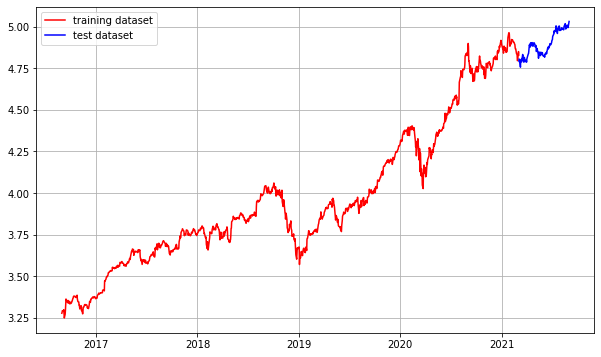

In [8]:
#데이터셋 분리 - 9:1로 분리함.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

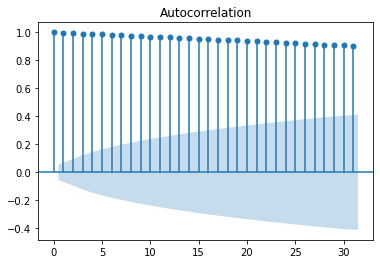

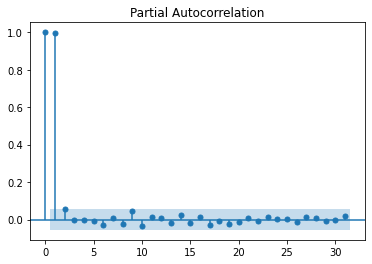

In [9]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p가 2 이상인 구간에서는 PACF는 거의 0에 가깝기 때문에 PACF 그래프를 근거로 p값이 1이 적합하다고 판단했다.
- ACF는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있다.
- q에 대해서는 적합한 값이 없어 보이기 때문에 q 값은 0으로 두었다.

Results of Dickey-Fuller Test:
Test Statistic                -1.099504e+01
p-value                        6.905416e-20
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.556187e+01
p-value                        2.037698e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64


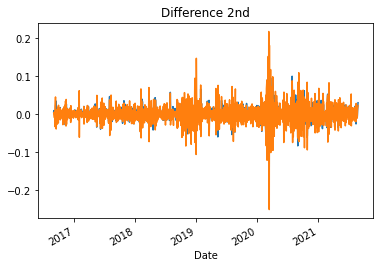

In [10]:
#차분 안정성 확인 -> d 구하기

#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분보다 1차 차분이 더 안정화 된 상태라고 판단하여 d 값을 1로 두었다.

In [19]:
#모델 학습 

from statsmodels.tsa.arima_model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 1, 0))  

#fitting model
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2856.502
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 31 Aug 2021   AIC                          -5707.003
Time:                        11:46:24   BIC                          -5691.911
Sample:                             1   HQIC                         -5701.301
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      2.689      0.007       0.000       0.002
ar.L1.D.Close    -0.1272      0.029     -4.312      0.000      -0.185      -0.069
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

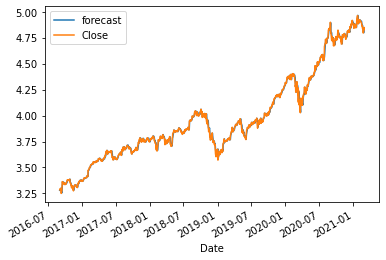

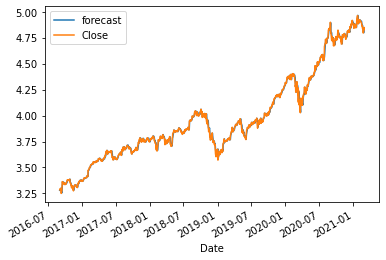

In [20]:
#훈련 결과 시각화
fitted_m.plot_predict()

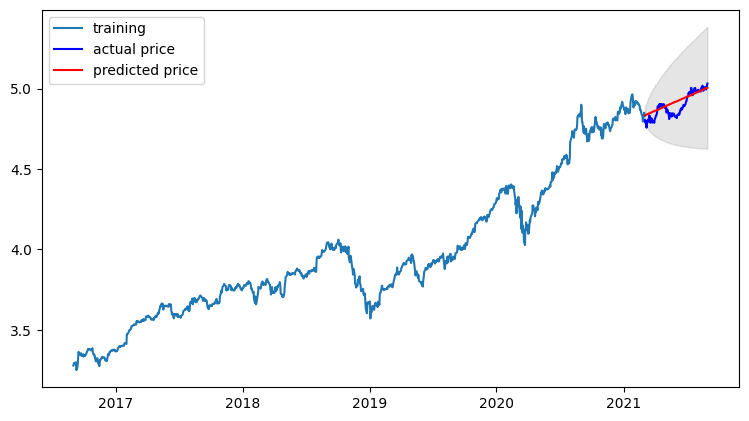

In [21]:
#테스트 데이터 구간의 데이터 예측

#Forecast : 결과가 fc에 담김.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  #예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  #예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [22]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 함.
#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산.

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  36.568265235280634
MAE:  4.875504658225268
RMSE:  6.047170018717899
MAPE: 3.79%


## 7.3 NVIDIA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#데이터 로드
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data1/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2016-08-31    15.3350
2016-09-01    15.7875
2016-09-02    15.6325
2016-09-06    15.7800
2016-09-07    15.5475
Name: Close, dtype: float64

In [2]:
#결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

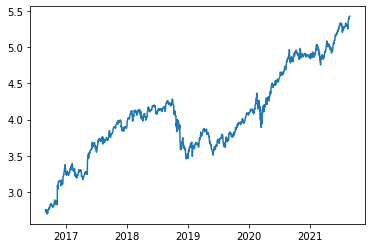

In [3]:
#로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

- NVIDIA는 2018년 말에 급락을 했기 때문에 안정성이 떨어져 예측에 영향을 미칠 것이라 판단하여 미리 데이터의 기간을 2019년 1월부터 현재까지로 조정했다.

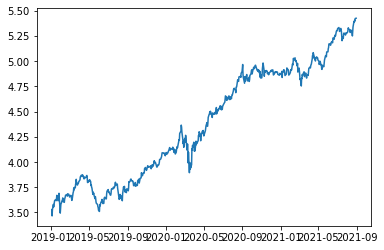

In [4]:
#데이터의 기간 조정하여 재 시도
ts_log = ts_log['2019-01-01' : ]
plt.plot(ts_log)

In [5]:
#일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
#마찬가지로 월 단위로 발생하는 시게열이므로 12개월 단위로 주기성이 있기 때문애 window를 12로 둠.
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    #이동표준편차 시계열

     #원본시계열, 이동평균, 이동표준편차를 plot으로 시각화.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


#statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

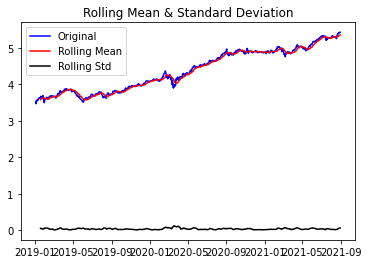

Results of Dickey-Fuller Test:
Test Statistic                   0.155647
p-value                          0.969661
#Lags Used                      13.000000
Number of Observations Used    657.000000
Critical Value (1%)             -3.440342
Critical Value (5%)             -2.865949
Critical Value (10%)            -2.569118
dtype: float64


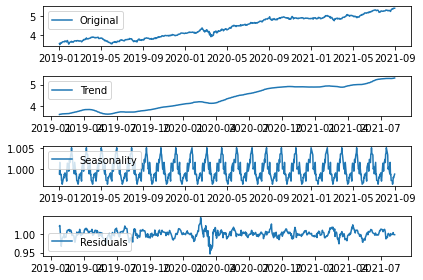

In [6]:
#정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.843200e+00
p-value                        5.862013e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.200000e+02
Critical Value (1%)           -3.440941e+00
Critical Value (5%)           -2.866213e+00
Critical Value (10%)          -2.569259e+00
dtype: float64


- residual의 p-value가 아주 낮은 값을 보여주는 것을 보아 예측 가능한 수준의 안정적인 시계열이라고 볼 수 있다.

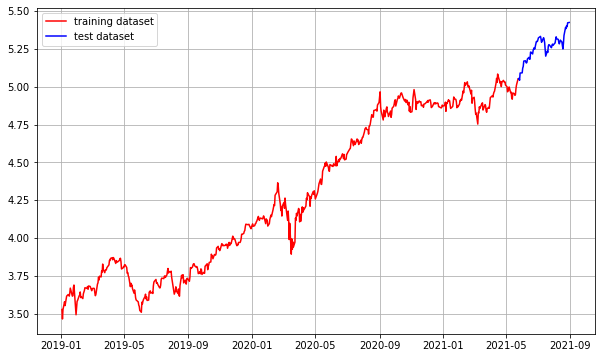

In [8]:
#데이터셋 분리 - 9:1로 분리함.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

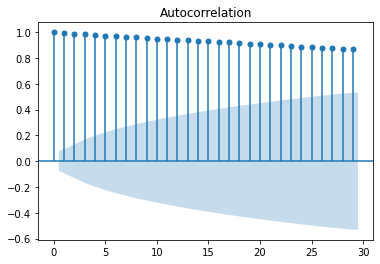

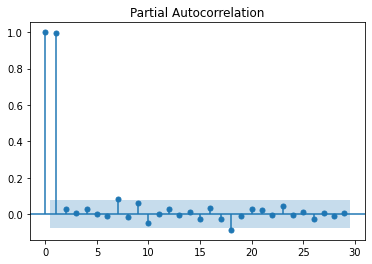

In [9]:
#ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   #ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  #PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p가 2 이상인 구간에서는 PACF는 거의 0에 가깝기 때문에 PACF 그래프를 근거로 p값이 1이 적합하다고 판단했다.
- ACF는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있다.
- q에 대해서는 적합한 값이 없어 보이기 때문에 q 값은 0으로 두었다.

Results of Dickey-Fuller Test:
Test Statistic                -7.758128e+00
p-value                        9.614653e-12
#Lags Used                     1.200000e+01
Number of Observations Used    6.570000e+02
Critical Value (1%)           -3.440342e+00
Critical Value (5%)           -2.865949e+00
Critical Value (10%)          -2.569118e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.169863e+01
p-value                        1.588342e-21
#Lags Used                     1.500000e+01
Number of Observations Used    6.530000e+02
Critical Value (1%)           -3.440404e+00
Critical Value (5%)           -2.865976e+00
Critical Value (10%)          -2.569132e+00
dtype: float64


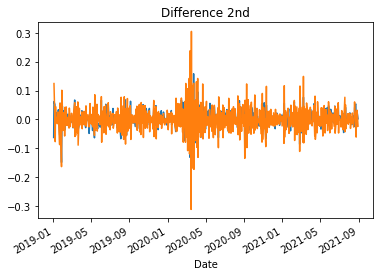

In [26]:
#차분 안정성 확인 -> d 구하기

#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분보다 1차 차분이 더 안정화 된 상태라고 판단하여 d 값을 1로 두었다.

In [36]:
#모델 학습 

from statsmodels.tsa.arima_model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 1, 2))  

#fitting model
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  602
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1246.743
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 31 Aug 2021   AIC                          -2483.485
Time:                        12:03:32   BIC                          -2461.484
Sample:                             1   HQIC                         -2474.922
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0025      0.001      2.310      0.021       0.000       0.005
ar.L1.D.Close    -0.3078      0.306     -1.005      0.315      -0.908       0.292
ma.L1.D.Close     0.1200      0.307     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


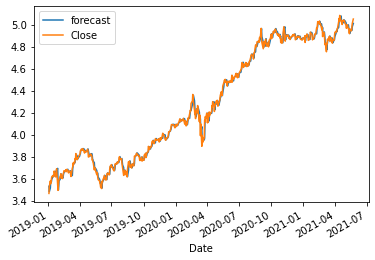

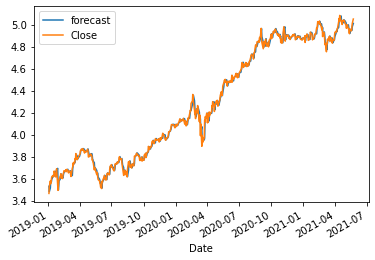

In [37]:
#훈련 결과 시각화
fitted_m.plot_predict()

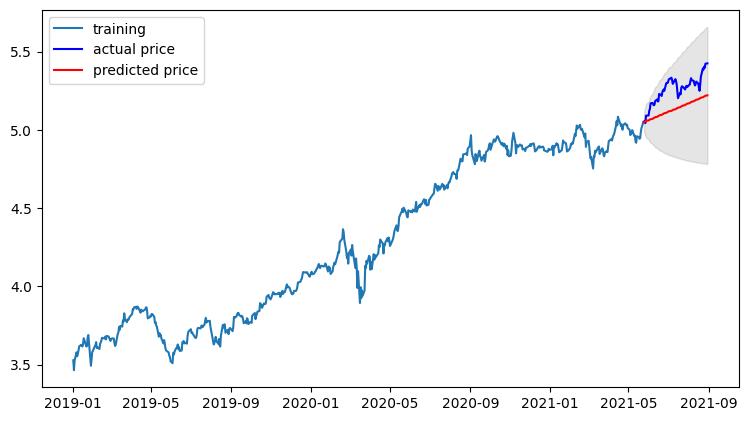

In [38]:
#테스트 데이터 구간의 데이터 예측

#Forecast : 결과가 fc에 담김.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  #95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   #예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  #예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  #예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [39]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 함.
#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산.

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  609.7565025547722
MAE:  22.588352905445646
RMSE:  24.693248116737745
MAPE: 11.42%


---

## - 프로젝트 정리   

### 1. (예제) 삼성전자     

![삼성 예측 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex14/results/samsung_predic.JPG?raw=true)   

- 예측은 상향으로 실제 경향과 비슷하게 나왔지만 값의 차이는 약간 있었다.    
- 코로나로 인해 투자 과열로 급등했다가 다시 하락하는 추세인 현 상황을 반영하지 못하기 때문에 안정성이 제대로 전제되지 않아 MAPE는 좋게 나왔지만 예측은 정확하게 하지 못한 것 같다.      
- p,d,q 값을 변경하면서 예측을 해 봤지만 1,1,0으로 했을 때 MAPE가 가장 좋게 나왔다.   


### 2. (7.1) 테슬라    

- 5년 전부터 현재까지의 데이터를 가지고 예측을 했더니 MAPE가 22.40%가 나왔다.   

![테슬라 데이터](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex14/results/tesla_origi.JPG?raw=true)   

- 데이터를 봤을 때 2019년 중후반 부터 갑자기 급등한 경향을 보였다.(아마도 화성, 코인의 영향인 듯)   
- 급등 전 후의 간격이 너무 커서 제대로 된 예측을 할 수 없었던 것은 아닐까 하여 기간을 2019년 8월부터 현재까지로 기간을 조정하여 다시 예측을 해 보았다.   

![테슬라 바꾼 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex14/results/tesla_new_predic.JPG?raw=true)   

- 데이터 기간을 2019년 8월부터 현재까지로 기간 조정을 하여 예측하였더니 예측 결과의 트렌드도 얼추 비슷했으며 MAPE도 5.96%로 좋게 나왔다.

### 3. (7.2) 애플   

![애플 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex14/results/apple_predic.JPG?raw=true)   

- 애플은 급증하는 구간이 없었으며 전반적으로 우상향 트렌드를 보여 기간 조정을 따로 해 주지 않았다.   
- 예측 트렌드와 실제 트렌드도 유사하며 MAPE가 3.79%로 좋게 나왔다.   
- 안정성이 제대로 전제 되었기 때문에 좋은 결과가 나왔다고 생각한다.   


### 4. (7.3) NVIDIA     

![엔비디아 결과](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex14/results/nvidia_predic.JPG?raw=true)   

- 엔비디아는 급락하는 구간이 있었기 때문에 안정성을 보장하기 위하여 기간 조정을 2019년 1월부터 현재까지로 해주었다.   
- p,d,q 값을 각각 1,1,0으로 했을 때 예측 트렌드는 비슷하나 MAPE가 11.69%로 나와서 p값을 0부터 차례로 올려보았다.   
- q 값이 3 이상일 때는 데이터의 양이 많지 않아서 시도 해 볼 수 없었다.   
- q 값이 2일 때 MAPE가 아주 약간 줄어들어 11.43%가 나왔다.      


### 5. 느낀점   

- p,d,q 값을 변경했을 때 예측 결과가 좋아지는 데이터도 있었다.   
- 하지만 큰 변화는 없었으며 예측 결과가 달라지지 않는 데이터도 있었다.
- 데이터의 기간을 조정하지 않았을 때 트렌드에 큰 변화가 있는 경우에는 residual의 p-value가 낮은 값을 가짐에도 불구하고 제대로 예측을 할 수 없었다.   
  - 이런 경우에는 정말 p,d,q 값의 변경이 무의미 했으며 데이터의 기간을 조정하는 것이 가장 최선의 방법이었다. 
  - 데이터의 기간을 조정하지 않고도 제대로 예측을 할 수 있는 방법을 좀 더 알아봐야 할 것 같다.